# Topological optimization of a graph approximation

In this notebook, we will explore whether we can conduct topological optimization of based on a graph approximation (and a function defined on the nodes thereof) of a point cloud data set.

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import numpy as np
import pandas as pd

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss

# Euclidean minimum spanning tree computation
import itertools
from scipy.spatial import Delaunay
from scipy.special import binom
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Generate and view data

We will generate a toy data set resembling a Y-structured topology.

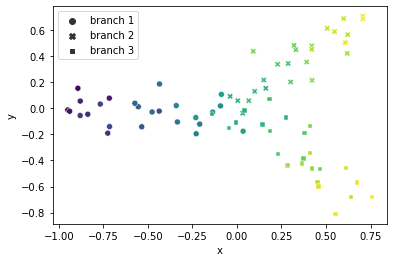

In [23]:
### generate the data
points_per_branch = 25
sigma = 0.1
branch1 = [[-1, 0], [0, 0]]
branch2 = [[0, 0], [np.sqrt(2) / 2, np.sqrt(2) / 2]]
branch3 = [[0, 0], [np.sqrt(2) / 2, -np.sqrt(2) / 2]]
nonoise = np.concatenate([np.transpose(np.array([np.linspace(branch1[0][0], branch1[1][0], points_per_branch),
                                                 np.linspace(branch1[0][1], branch1[1][1], points_per_branch)])),
                          np.transpose(np.array([np.linspace(branch2[0][0], branch2[1][0], points_per_branch),
                                                 np.linspace(branch2[0][1], branch2[1][1], points_per_branch)])),
                          np.transpose(np.array([np.linspace(branch3[0][0], branch3[1][0], points_per_branch),
                                                 np.linspace(branch3[0][1], branch3[1][1], points_per_branch)]))])
np.random.seed(42)
data = pd.DataFrame(nonoise +  np.random.normal(loc=0.0, scale=sigma, size=[points_per_branch * 3, 2]),
                    columns=["x", "y"])
branch_label = np.repeat(["branch 1", "branch 2", "branch 3"], points_per_branch)
time_label = nonoise[:,0]

# Plot the data
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x", y="y", c=time_label, style=branch_label, ax=ax)
plt.show()

The topological optimization will be conducted through the Euclidean minimum spanning tree (MST) of the point cloud, and the graph eccentricity function evaluated thereon. We plot these for the original data below.

In [35]:
def get_minimum_spanning_tree(x):
    # compute Delaunay triangulation of x
    x = np.array(x.copy())
    tri = Delaunay(x)
    # obtain the graph skeleton of the triangulation
    V = np.zeros(len(tri.simplices) * int(binom(x.shape[1] + 1, 2)))
    I = V.copy().astype(int)
    J = I.copy()
    for idx1, s in enumerate(tri.simplices):
        for idx2, (i, j) in enumerate(itertools.combinations(s, 2)):
            idx = 3 * idx1 + idx2
            I[idx] = i
            J[idx] = j
            V[idx] = np.linalg.norm(x[i] - x[j])
    G = coo_matrix((V, (I, J)), shape=(x.shape[0], x.shape[0])).tocsr()
    # obtain the minimum spanning tree and store as simplicial complex
    return minimum_spanning_tree(G)

def graph_to_complex(G):
    E = G.nonzero()
    n = len(E[0]) + 1
    return [[i]for i in range(n)] + [([E[0][idx], E[1][idx]]) for idx in range(n - 1)]

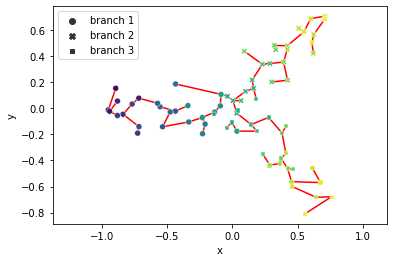

In [37]:
# Plot the data and minimum spanning tree
MST = graph_to_complex(get_minimum_spanning_tree(data))
fig, ax = plt.subplots()
for s in MST:
    if len(s) == 2:
        plt.plot([data.iloc[s[0], 0], data.iloc[s[1], 0]], [data.iloc[s[0], 1], data.iloc[s[1], 1]], 
                 c="red", zorder=0)
sns.scatterplot(data=data, x="x", y="y", c=time_label, style=branch_label, ax=ax, zorder=1)
ax.axis("equal")
plt.show()

## Apply topological optimization to the embedding

We now show how we can use topological optimization to encourage the model underlying the data to become connected. As a topological loss, we will use the total (finite) 0-dimensional persistence.

In [3]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=0) # alpha complex layer
TotalPersistence = DiagramLoss(dim=0, i=2, g=g) # compute total finite 0-dimensional persistence

# Construct topological loss function
def top_loss(output):
    dgminfo = TopLayer(output)            
    loss = TotalPersistence(dgminfo)
    
    return loss

We can now conduct the topological optimization as follows.

In [4]:
# Dictionary to store optimized point cloud for multiple epochs
optimized = dict()

# Learning hyperparameters
num_epochs = [5, 50, 100, 250, 500, 1000]
learning_rate = 1e0

# Conduct topological optimization
Y = torch.autograd.Variable(torch.tensor(np.array(data.loc[:,["x","y"]])).type(torch.float), requires_grad=True)
optimizer = torch.optim.Adam([Y], lr=learning_rate)

for epoch in range(num_epochs[len(num_epochs) - 1]):
    optimizer.zero_grad()
    loss = top_loss(Y)
    loss.backward()
    optimizer.step()

    if epoch == 0 or (epoch + 1) % (int(num_epochs[len(num_epochs) - 1]) / 10) == 0:
        print ("[epoch %d] [topological loss: %f]" % (epoch + 1, loss.item()))
        
    if epoch + 1 in num_epochs:
        optimized[epoch + 1] = Y.detach().numpy().copy()

[epoch 1] [topological loss: 457.542542]
[epoch 100] [topological loss: 129.146744]
[epoch 200] [topological loss: 93.165222]
[epoch 300] [topological loss: 84.318512]
[epoch 400] [topological loss: 78.541626]
[epoch 500] [topological loss: 77.293060]
[epoch 600] [topological loss: 74.688240]
[epoch 700] [topological loss: 69.911301]
[epoch 800] [topological loss: 70.679962]
[epoch 900] [topological loss: 65.238800]
[epoch 1000] [topological loss: 66.778046]


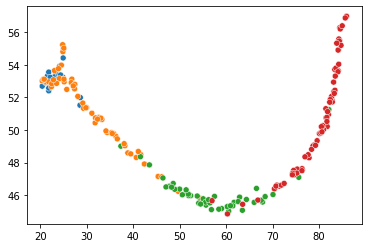

In [5]:
# View topologically optimized data for a particular number of epochs
epoch = 250
fig, ax = plt.subplots()
sns.scatterplot(x=optimized[epoch][:,0], y=optimized[epoch][:,1], hue=data.loc[:,"group"], ax=ax)
ax.legend().remove()
plt.show()

Finally, we save the optimized data sets for plotting in R.

In [6]:
for epoch in num_epochs:
    np.savetxt(os.path.join("Data", "ICLR Optimized" , "epochs" + str(epoch) + ".csv"), 
               optimized[epoch], delimiter=",")